# Unified TFIM / XY Imaginary-Time Simulation

This notebook provides a unified Python implementation of the imaginary-time simulation framework.

It supports:
- **Transverse-Field Ising Model (TFIM)**
- **XY model**

in **1D** and **2D** geometries, using Qiskit-based circuits to:
- build the corresponding lattice Hamiltonian,
- perform imaginary-time / thermal evolution,
- estimate thermal averages of the energy,
- compare estimated quantities to exact results from diagonalization.

The central entry point is:

```python
run_model_experiment(model, lattice_size, trotter_steps)


## 1. Imports 

This section imports the numerical and quantum-computing (Qiskit) libraries used in the
simulation:

In [9]:
import qiskit
import qiskit_ibm_runtime
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.optimize import curve_fit
from scipy.integrate import cumulative_trapezoid

from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.transpiler import generate_preset_pass_manager
from qiskit.circuit import Parameter



## 2. Lattice Geometry and Utility Functions

The helper functions in this section define the lattice connectivity and
basic linear-algebra utilities:


These tools are shared by both TFIM and XY models, ensuring that the same
geometric routine can be reused for different Hamiltonians.


In [ ]:
def get_nearest_neighbor_interactions(lattice_size: list[int]) -> list[tuple[int, int]]:
    """
    Generate nearest-neighbor interactions pairs for 1D chains or 2D rectangular lattices.

    Args:
        lattice_size (list[int]): A list containing [rows, cols]. 
                                  Example: [1, 5] or [5,1] for 1D, [4, 5] for 2D.

    Returns:
        list[tuple[int,int]]: list of (i,j) index pairs for nearest-neighbor couplings.
    """
    # Validate input
    if not (isinstance(lattice_size, list) and len(lattice_size) == 2):
        raise ValueError("lattice_size must be a list of two integers [rows, cols].")
    
    rows, cols = lattice_size

    if not (isinstance(rows, int) and isinstance(cols, int) and rows > 0 and cols > 0):
        raise ValueError("Both rows and cols must be positive integers.")

    num_qubits = rows * cols
    interactions = []

    # Get dimension and calculate interactions
    # Check for 1D (linear chain)
    if rows == 1 or cols == 1:
        
        interactions = [(i, i + 1) for i in range(num_qubits - 1)]

    # Check for 2D (full rectangular lattice)
    else:
        for i in range(num_qubits):
            # right neighbor 
            if (i + 1) % cols != 0:
                interactions.append((i, i + 1))

            # down neighbor
            if i + cols < num_qubits:
                interactions.append((i, i + cols))

    return interactions

def kron_matrices(pauli_string: str) -> np.ndarray:
    """
    Compute the Kronecker product for a given Pauli string.

    Args:
        pauli_string (str): String representing the Pauli operators (e.g., 'ZZX').

    Returns:
        np.ndarray: The resulting matrix from the Kronecker product.
    """
    I_g = np.array([[1, 0], [0, 1]], dtype=complex)
    X_g = np.array([[0, 1], [1, 0]], dtype=complex)
    Z_g = np.array([[1, 0], [0, -1]], dtype=complex)
    pauli_dict = {'I': I_g, 'X': X_g, 'Z': Z_g}

    result = pauli_dict[pauli_string[0]]
    for char in pauli_string[1:]:
        result = np.kron(result, pauli_dict[char])
    return result

def thermal_average_H_H2(beta: float, lambda_n: np.ndarray) -> tuple[float, float]:
    """
    Calculate the thermal average of the Hamiltonian, and its square at a given beta.

    Args:
        beta (float): Inverse temperature.
        lambda_n (np.ndarray): Eigenvalues of the Hamiltonian.

    Returns:
        float: Thermal average <H>.
    """
    w = np.exp(-beta * lambda_n)
    Z_f = np.sum(w)
    H = float(np.sum(w * lambda_n) / Z_f)
    H2 = float(np.sum(w * lambda_n**2) / Z_f)
    return H, H2

def exp_func(beta: np.ndarray | float, a: float, b: float, c: float) -> np.ndarray | float:
    """
    Exponential decay function for curve fitting.

    Args:
        beta (np.ndarray | float): Input value(s).
        a (float): Amplitude.
        b (float): Decay rate.
        c (float): Offset.

    Returns:
        np.ndarray | float: Function value(s).
    """
    return a * np.exp(-beta * b) + c

def compute_free_energy_and_entropy(beta: np.ndarray, thermal_H: np.ndarray) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Compute the 'constant-free' free energy and entropy from thermal averages.

    Definitions used:
        F_tilde(β) = ( 1 / β ) * ∫_{β0}^{β} <H>(β') dβ'
        S_tilde(β) = β * ( <H>(β) - F_tilde(β) )

    These omit the additive constant A/β that would normally appear in the
    true free energy. This is intentional since both simulated and exact
    results are compared without the constant.

    Parameters
    ----------
    beta : np.ndarray
        1D array of β values (inverse temperature).
        Must be strictly increasing and beta[0] > 0.

    H_expect : np.ndarray
        1D array of thermal expectation values <H>(β).
        Must be the same shape as beta.

    Returns
    -------
    F_tilde : np.ndarray
        The constant-free free energy evaluated at each β.

    S_tilde : np.ndarray
        The constant-free entropy evaluated at each β.

    Notes
    -----
    - No constant term is added.
    - βeta = 0 is not supported (division by zero).
    - βeta must be sorted to exclude beta = 0.
    """
    beta_tilde = beta[1:]
    thermal_H_tilde = thermal_H[1:]

    F_tilde = 1/beta_tilde * (cumulative_trapezoid(thermal_H_tilde, beta_tilde, initial=0.0))

    S_tilde = beta_tilde * (thermal_H_tilde - F_tilde)

    return F_tilde, S_tilde


## 3. Model Core Functions: TFIM and XY

This section defines model-specific routines that construct and simulate
different spin models:

In [11]:
def tfim_generalized(lattice_size: list[int], trotter_steps: int) -> dict:
    """
    Implements Cuomo's guage-invarinat ITE for a transverse field Ising model in 1D or 2D.

    Args:
        lattice_size (list[int]): A list containing [rows, cols]. 
                                  Example: [1, 5] or [5,1] for 1D, [4, 5] for 2D.
        trotter_steps (int): Total number of Trotter steps to use in the circuit.

    Returns:
        dict: Dictionary containing the quantum circuit, results, and other computed values.

    Raises:
        ValueError: If lattice_size is not a list of two integers,
                    or if the total number of qubits exceeds 20 (to avoid high memory usage).
    """
    if not (isinstance(lattice_size, list) and len(lattice_size) == 2):
        raise ValueError("lattice_size must be a list of two integers [rows, cols].")
    
    rows, cols = lattice_size

    if not (isinstance(rows, int) and isinstance(cols, int) and rows > 0 and cols > 0):
        raise ValueError("Both rows and cols must be positive integers.")
    
    num_qubits = rows * cols

    if rows == 1 or cols == 1:
        dimension = 1
    else:
        dimension = 2

    zz_interaction_list = get_nearest_neighbor_interactions(lattice_size)
    total_hamiltonian_terms = num_qubits + len(zz_interaction_list)
    total_num_qubits = 2*num_qubits + total_hamiltonian_terms

    # Check for simulation feasibility; good when running on a low-end to mid-range PC
    if total_num_qubits > 20:
        raise ValueError(
            f"Total qubits required ({total_num_qubits}) exceeds 20. "
            "Simulation may require excessive memory. Consider reducing num_qubits or trotter_steps."
        )

    # Define parameters and PauliEvolutionGates
    γ = Parameter('γ')
    η = Parameter('η')
    β = Parameter('β')
    X = SparsePauliOp('X')
    Z = SparsePauliOp('Z')
    ZZZ = PauliEvolutionGate(Z ^ Z ^ Z, time=(β / (2 * trotter_steps)) * γ)
    ZX = PauliEvolutionGate(Z ^ X, time=(β / (2 * trotter_steps)) * η)

    # Create quantum circuit
    tfim_qc_sym = QuantumCircuit(total_num_qubits)

    # Create maximally mixed state for system qubits
    for ind in range(num_qubits):
        tfim_qc_sym.h(ind)
        tfim_qc_sym.cx(ind, total_num_qubits - 1 - ind)  
    tfim_qc_sym.barrier()

    # Prepare auxiliary qubits in |+> state
    aux_start = num_qubits
    aux_end = total_num_qubits - num_qubits
    for ind in range(aux_start, aux_end):
        tfim_qc_sym.h(ind)
    tfim_qc_sym.barrier()

    # Apply evolution gates in Trotter steps
    for _ in range(trotter_steps):
        # ZZZ operations
        for ind, zz_interaction in enumerate(zz_interaction_list):
            tfim_qc_sym.append(ZZZ, [zz_interaction[0], zz_interaction[1], num_qubits + ind])
        tfim_qc_sym.barrier()

        # ZX operations
        for ind in range(num_qubits):
            tfim_qc_sym.append(ZX, [ind, num_qubits + len(zz_interaction_list) + ind])
        tfim_qc_sym.barrier()

    # Rotate auxiliary qubits to the measurement basis
    for ind in range(aux_start, aux_end):
        tfim_qc_sym.sx(ind)

    # Build circuit Hamiltonians for SparsePauliOp
    ZZZ_list = []
    ZX_list = []
    for ind, zz_interaction in enumerate(zz_interaction_list):
        h_term = list('I' * total_num_qubits)
        h_term[zz_interaction[0]], h_term[zz_interaction[1]], h_term[num_qubits + ind] = 'Z', 'Z', 'Z'
        ZZZ_list.append(''.join(h_term)[::-1])

    for ind in range(num_qubits):
        h_term = list('I' * total_num_qubits)
        h_term[ind], h_term[num_qubits + len(zz_interaction_list) + ind] = 'X', 'Z'
        ZX_list.append(''.join(h_term)[::-1])

    hamiltonian_terms = ZZZ_list + ZX_list
    hamiltonian_terms_coeff = [γ] * len(ZZZ_list) + [η] * len(ZX_list)

    # Build and parameterize Hamiltonian
    tfim_hamiltonian = SparsePauliOp(hamiltonian_terms, coeffs=hamiltonian_terms_coeff)
    tfim_hamiltonian = tfim_hamiltonian.assign_parameters({γ: pi / 4, η: pi / 4}) # using a fixed-value pi/4 for the params 

    # qiskit needs complex-typed coefficients for tfim_hamiltonian
    # only 'SparsePauliOp' with complex-typed coefficients can be converted to 'SparseObservable'
    tfim_hamiltonian = SparsePauliOp(tfim_hamiltonian.paulis, coeffs=np.asarray(tfim_hamiltonian.coeffs, dtype=np.complex128))
    tfim_hamiltonian_sq = (tfim_hamiltonian @ tfim_hamiltonian).simplify() # gets the SparsePauliOp of the square

    tfim_output = {
        'qc': tfim_qc_sym, 'hamiltonian': tfim_hamiltonian, 'hamiltonian_sq': tfim_hamiltonian_sq,
        'hamiltonian_terms_0': ZZZ_list, 'hamiltonian_terms_1': ZX_list,
        'total_num_qubits': total_num_qubits,
        'gamma_param': γ,
        'eta_param': η,
        'beta_param': β
    }

    return tfim_output


def xy_generalized(lattice_size: list[int], trotter_steps: int) -> dict:
    """
    Implements Cuomo's guage-invarinat ITE for an XY model in 1D or 2D.

    Args:
        lattice_size (list[int]): A list containing [rows, cols]. 
                                  Example: [1, 5] or [5,1] for 1D, [4, 5] for 2D.
        trotter_steps (int): Total number of Trotter steps to use in the circuit.

    Returns:
        dict: Dictionary containing the quantum circuit, results, and other computed values.

    Raises:
        ValueError: If lattice_size is not a list of two integers,
                    or if the total number of qubits exceeds 20 (to avoid high memory usage).
    """

    if not (isinstance(lattice_size, list) and len(lattice_size) == 2):
        raise ValueError("lattice_size must be a list of two integers [rows, cols].")
    
    rows, cols = lattice_size

    if not (isinstance(rows, int) and isinstance(cols, int) and rows > 0 and cols > 0):
        raise ValueError("Both rows and cols must be positive integers.")
    
    num_qubits = rows * cols

    if rows == 1 or cols == 1:
        dimension = 1
    else:
        dimension = 2

    interaction_list = get_nearest_neighbor_interactions(lattice_size)
    total_hamiltonian_terms = 2 * len(interaction_list)
    total_num_qubits = 2*num_qubits + total_hamiltonian_terms

    # Check for simulation feasibility
    if total_num_qubits > 20:
        raise ValueError(
            f"Total qubits required ({total_num_qubits}) exceeds 20. "
            "Simulation may require excessive memory. Consider reducing num_qubits or trotter_steps."
        )

    # Define parameters and PauliEvolutionGates
    γ = Parameter('γ') # we are taking all the coefficients to be equal and == pi/4
    β = Parameter('β')
    X = SparsePauliOp('X')
    Z = SparsePauliOp('Z')
    ZZZ = PauliEvolutionGate(Z ^ Z ^ Z, time=(β / (2 * trotter_steps)) * γ)
    ZXX = PauliEvolutionGate(Z ^ X ^ X, time=(β / (2 * trotter_steps)) * γ)

    # Create quantum circuit
    xy_qc_sym = QuantumCircuit(total_num_qubits)

    # Create maximally mixed state for system qubits
    for ind in range(num_qubits):
        xy_qc_sym.h(ind)
        xy_qc_sym.cx(ind, total_num_qubits - 1 - ind)  
    xy_qc_sym.barrier()

    # Prepare auxiliary qubits in |+> state
    aux_start = num_qubits
    aux_end = total_num_qubits - num_qubits
    for ind in range(aux_start, aux_end):
        xy_qc_sym.h(ind)
    xy_qc_sym.barrier()

    # Apply evolution gates in Trotter steps
    for _ in range(trotter_steps):
        for ind, interaction in enumerate(interaction_list):
            xy_qc_sym.append(ZZZ, [interaction[0], interaction[1], num_qubits + ind])
            xy_qc_sym.append(ZXX, [interaction[0], interaction[1], num_qubits + ind + len(interaction_list)])

        xy_qc_sym.barrier()

    # Rotate auxiliary qubits to the measurement basis
    for ind in range(aux_start, aux_end):
        xy_qc_sym.sx(ind)

    # Build circuit Hamiltonians for SparsePauliOp
    ZZZ_list = []
    ZXX_list = []
    for ind, interaction in enumerate(interaction_list):
        h_term = list('I' * total_num_qubits)
        h_term[interaction[0]], h_term[interaction[1]], h_term[num_qubits + ind] = 'Z', 'Z', 'Z'
        ZZZ_list.append(''.join(h_term)[::-1])

    for ind, interaction in enumerate(interaction_list):
        h_term = list('I' * total_num_qubits)
        h_term[interaction[0]], h_term[interaction[1]], h_term[num_qubits + ind + len(interaction_list)]  = 'X', 'X', 'Z'
        ZZZ_list.append(''.join(h_term)[::-1])

    hamiltonian_terms = ZZZ_list + ZXX_list
    hamiltonian_terms_coeff = [γ] * len(hamiltonian_terms)

    # Build and parameterize Hamiltonian
    xy_hamiltonian = SparsePauliOp(hamiltonian_terms, coeffs=hamiltonian_terms_coeff)
    xy_hamiltonian = xy_hamiltonian.assign_parameters({γ: pi / 4})

    # qiskit needs complex-typed coefficients for xy_hamiltonian
    # only 'SparsePauliOp' with complex-typed coefficients can be converted to 'SparseObservable'
    xy_hamiltonian = SparsePauliOp(xy_hamiltonian.paulis, coeffs=np.asarray(xy_hamiltonian.coeffs, dtype=np.complex128))
    xy_hamiltonian_sq = (xy_hamiltonian @ xy_hamiltonian).simplify() # gets the SparsePauliOp of the square


    xy_output = {
        'qc': xy_qc_sym, 'hamiltonian': xy_hamiltonian, 'hamiltonian_sq': xy_hamiltonian_sq,
        'hamiltonian_terms_0': ZZZ_list, 'hamiltonian_terms_1': ZXX_list,
        'total_num_qubits': total_num_qubits,
        'gamma_param': γ,
        'beta_param': β
    }


    return xy_output



## 4. Unified Experiment Runner

The function

```python
run_model_experiment(model, dimension, num_qubits, trotter_steps)


In [22]:
def run_model_experiment(model: str, lattice_size: list[int], trotter_steps: int):
    """
    Unified experiment runner for both TFIM and XY models.
    Builds, simulates, and plots results for the chosen model.
    """

    model = model.lower()
    if model == "tfim":
        sim = tfim_generalized(lattice_size, trotter_steps)
    elif model == "xy":
        sim = xy_generalized(lattice_size, trotter_steps)
    else:
        raise ValueError("Model must be 'tfim' or 'xy'.")
    
    rows, cols = lattice_size
    
    num_qubits = rows * cols

    if rows == 1 or cols == 1:
        dimension = 1
    else:
        dimension = 2

    qc = sim["qc"]
    hamiltonian = sim["hamiltonian"]
    hamiltonian_sq = sim["hamiltonian_sq"]
    hamiltonian_terms_0, hamiltonian_terms_1 = sim['hamiltonian_terms_0'], sim['hamiltonian_terms_1']
    total_num_qubits = sim["total_num_qubits"]

    # Sweep beta values
    beta_vals = np.linspace(0.0, 1.4, 11)
    backend = AerSimulator(method='statevector')
    pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
    transpile_result = []

    if model == "tfim":
        gamma_param = sim['gamma_param']
        eta_param   = sim['eta_param']
        beta_param  = sim['beta_param']
    else:  # model == "xy"
        gamma_param = sim['gamma_param']
        beta_param  = sim['beta_param']

    for val in beta_vals:
        if model == "tfim":
            psi = qc.assign_parameters({gamma_param: pi / 4, eta_param: pi / 4, beta_param: -val})
        else:
            psi = qc.assign_parameters({gamma_param: pi / 4, beta_param: -val})
        isa_psi = pm.run(psi)
        isa_hamiltonian = hamiltonian.apply_layout(isa_psi.layout)
        isa_hamiltonian_sq = hamiltonian_sq.apply_layout(isa_psi.layout)
        transpile_result.append({'beta_val': val, 'isa_psi': isa_psi, 'isa_hamiltonian': isa_hamiltonian, 'isa_hamiltonian_sq': isa_hamiltonian_sq})

    # Estimate expectation values
    estimator = Estimator(mode=backend, options={'default_shots': 10000})
    estimated_store = []
    for item in transpile_result:
        job = estimator.run([(item['isa_psi'], item['isa_hamiltonian'])]).result()[0]
        job_sq = estimator.run([(item['isa_psi'], item['isa_hamiltonian_sq'])]).result()[0]
        expectation_val = job.data.evs
        expectation_val_sq = job_sq.data.evs
        expectation_val_std = job.data.stds
        estimated_variance = expectation_val_sq - (expectation_val**2)
        estimated_store.append((item['beta_val'], expectation_val, expectation_val_sq, estimated_variance, expectation_val_std))

    final_betas, estimated_thermal_avgs, estimated_thermal_avgs_sq, estimated_variance, expectation_val_std = zip(*estimated_store)
    final_betas, estimated_thermal_avgs, expectation_val_std = np.array(final_betas), np.array(estimated_thermal_avgs), np.array(expectation_val_std)

    # Exact diagonalization
    gamma = pi / 4
    eta = pi/4 if model == "tfim" else None

    if model == "tfim":
        ZZ_list_exact = [ind[::-1][:num_qubits] for ind in hamiltonian_terms_0]
        X_list_exact = [ind[::-1][:num_qubits] for ind in hamiltonian_terms_1]

        H_exact = (gamma * sum(kron_matrices(pauli_string) for pauli_string in ZZ_list_exact)) + \
                    (eta * sum(kron_matrices(pauli_string) for pauli_string in X_list_exact))

    else:
        ZZ_list_exact = [ind[::-1][:num_qubits] for ind in hamiltonian_terms_0]
        XX_list_exact = [ind[::-1][:num_qubits] for ind in hamiltonian_terms_1]

        H_exact = (gamma * sum(kron_matrices(pauli_string) for pauli_string in ZZ_list_exact)) + \
                        (gamma * sum(kron_matrices(pauli_string) for pauli_string in XX_list_exact))

    lambda_n, _ = np.linalg.eigh(H_exact)
    exact_thermal_avgs = np.array([thermal_average_H_H2(final_beta, lambda_n)[0] for final_beta in final_betas])
    exact_variance = np.array([(thermal_average_H_H2(final_beta, lambda_n)[1] - thermal_average_H_H2(final_beta, lambda_n)[0]**2) for final_beta in final_betas])

    # Get the normalized RMSE (Root-mean-square error) between the estimated and expected thermal averages
    delta_averages = estimated_thermal_avgs - exact_thermal_avgs
    exact_range = np.max(exact_thermal_avgs) - np.min(exact_thermal_avgs)
    rmse = np.sqrt(np.mean(delta_averages**2))
    nrmse = (1 - (rmse/exact_range)) * 100

    # Curve fitting
    fit_sim_params, _ = curve_fit(exp_func, final_betas, estimated_thermal_avgs, p0=[1, 1, 0])
    fit_exact_params, _ = curve_fit(exp_func, final_betas, exact_thermal_avgs, p0=[1, 1, 0])

    fitted_estimated_avgs = exp_func(final_betas, *fit_sim_params)
    fitted_exact_avgs = exp_func(final_betas, *fit_exact_params)

    min_eigenval = np.min(lambda_n)

    # Get the free energy and entropy
    sim_free_energy, sim_entropy = compute_free_energy_and_entropy(final_betas, estimated_thermal_avgs)
    exact_free_energy, exact_entropy = compute_free_energy_and_entropy(final_betas, exact_thermal_avgs)
    


    print(f"\n=== {model.upper()}_{dimension}D Simulation Summary ===")
    print(f"Dimension: {dimension}D")
    print(f"System qubits: {num_qubits}")
    print(f"Total qubits (with auxiliary qubits): {total_num_qubits}")
    print(f"Trotter steps: {trotter_steps}")
    print(f"NRMSE: {nrmse:.2f}%\n")

    qc.draw('mpl', scale=0.5, fold = 1000)

    fig = plt.figure(figsize=(10, 8))
    ax = plt.subplot(2,2,1)
    ax.scatter(final_betas, estimated_thermal_avgs, color='lightgreen', label=r'sim_$\langle H \rangle$')
    # ax.errorbar(final_betas, estimated_thermal_avgs, yerr=expectation_val_std, fmt='none', color='lightgreen', capsize=1)
    ax.plot(final_betas, fitted_estimated_avgs, color='lightgreen', linestyle='--')
    ax.scatter(final_betas, exact_thermal_avgs, color='skyblue', label=r'exact_$\langle H \rangle$')
    ax.plot(final_betas, fitted_exact_avgs, color='skyblue', linestyle='-')
    if min_eigenval is not None:
        ax.axhline(y=min_eigenval, linestyle=':', linewidth=2, label='ground')
    ax.set_xlabel(r'$\beta$'); ax.set_ylabel(r'Thermal average ($\langle H \rangle$)')
    if min_eigenval is not None:
        ax.set_ylim(min_eigenval + (0.1 * min_eigenval))
    ax.grid(True, alpha=0.5); ax.legend()

    # plot Free energy
    ax = plt.subplot(2,2,2)
    ax.scatter(final_betas[1:], sim_free_energy, color='lightgreen', label = r'sim_$F(\beta)$')
    ax.plot(final_betas[1:], sim_free_energy, color='lightgreen')
    ax.scatter(final_betas[1:],exact_free_energy, color='skyblue', label= r'exact_$F(\beta)$')
    ax.plot(final_betas[1:], exact_free_energy, color='skyblue')
    ax.set_xlabel(r'$\beta$'); ax.set_ylabel('Free Energy')
    ax.grid(True, alpha=0.5); ax.legend()

    # plot entropy
    ax = plt.subplot(2,2,3)
    ax.scatter(final_betas[1:], sim_entropy, color='lightgreen', label = r'sim_$S(\beta)$')
    ax.plot(final_betas[1:], sim_entropy, color='lightgreen')
    ax.scatter(final_betas[1:],exact_entropy, color='skyblue', label= r'exact_$S(\beta)$')
    ax.plot(final_betas[1:], exact_entropy, color='skyblue')
    ax.set_xlabel(r'$\beta$'); ax.set_ylabel('Entropy')
    ax.grid(True, alpha=0.5); ax.legend()


    # plot variance
    ax = plt.subplot(2,2,4)
    ax.scatter(final_betas, estimated_variance, color='lightgreen', label = 'sim_var')
    ax.plot(final_betas, estimated_variance, color='lightgreen')
    ax.scatter(final_betas, exact_variance, color='skyblue', label='exact_var')
    ax.plot(final_betas, exact_variance, color='skyblue')
    ax.set_xlabel(r'$\beta$'); ax.set_ylabel('Var(H)')
    ax.grid(True, alpha=0.5); ax.legend()
    
    plt.tight_layout(); plt.show()

    output =  {
        'model': model,
        'simulation': sim,
        'estimated_thermal_avgs': estimated_thermal_avgs,
        'exact_thermal_avgs': exact_thermal_avgs,
        'estimated_variance': estimated_variance,
        'exact_variance': exact_variance,
        'nrmse': nrmse,
        'final_betas': final_betas,
        'fitted_estimated_avgs': fitted_estimated_avgs,
        'fitted_exact_avgs': fitted_exact_avgs,
        'min_eigenval': min_eigenval,
        'sim_free_energy': sim_free_energy,
        'sim_entropy': sim_entropy,
        'exact_free_energy': exact_free_energy,
        'exact_entropy': exact_entropy
    }

    return output


## 5. Example Usage

The following example shows how to launch a single simulation directly
from the notebook 


=== XY_2D Simulation Summary ===
Dimension: 2D
System qubits: 4
Total qubits (with auxiliary qubits): 16
Trotter steps: 2
NRMSE: 95.17%



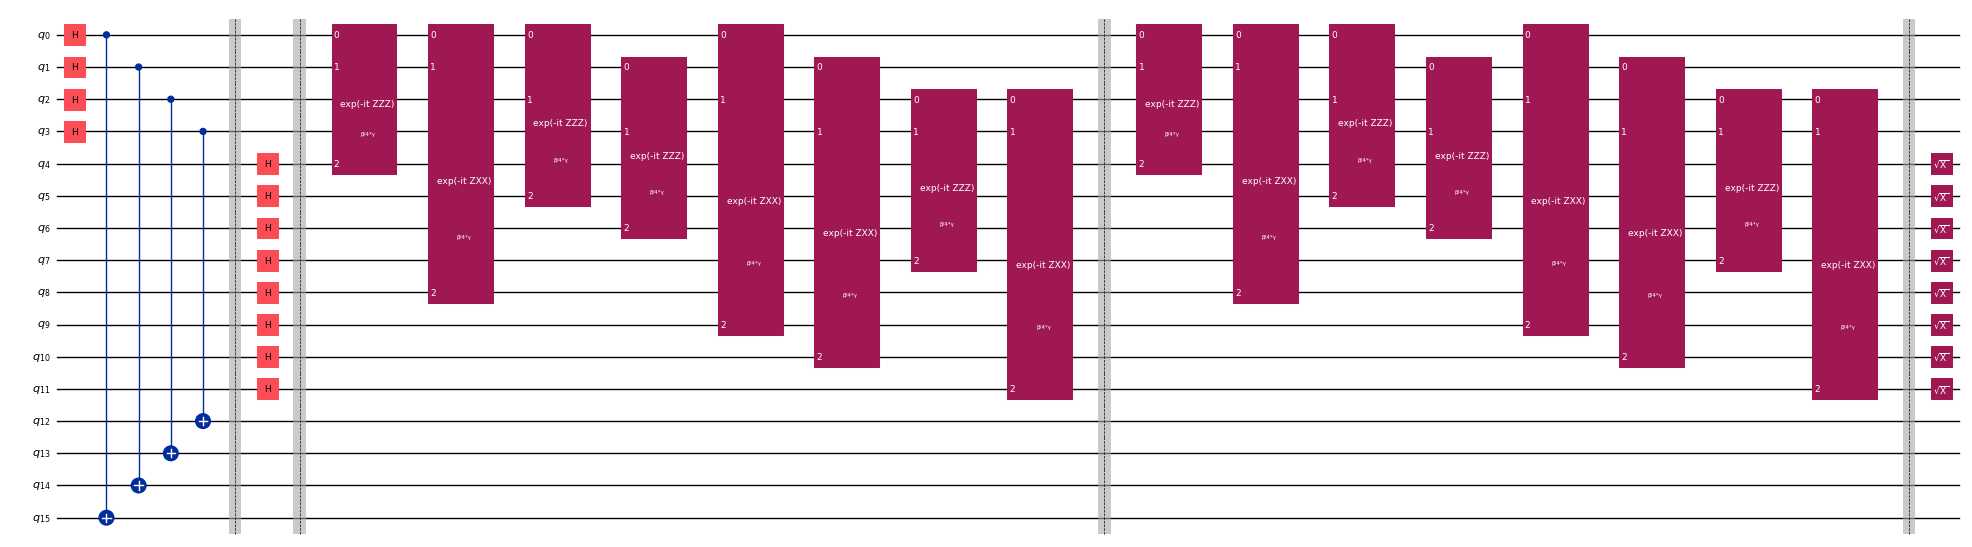

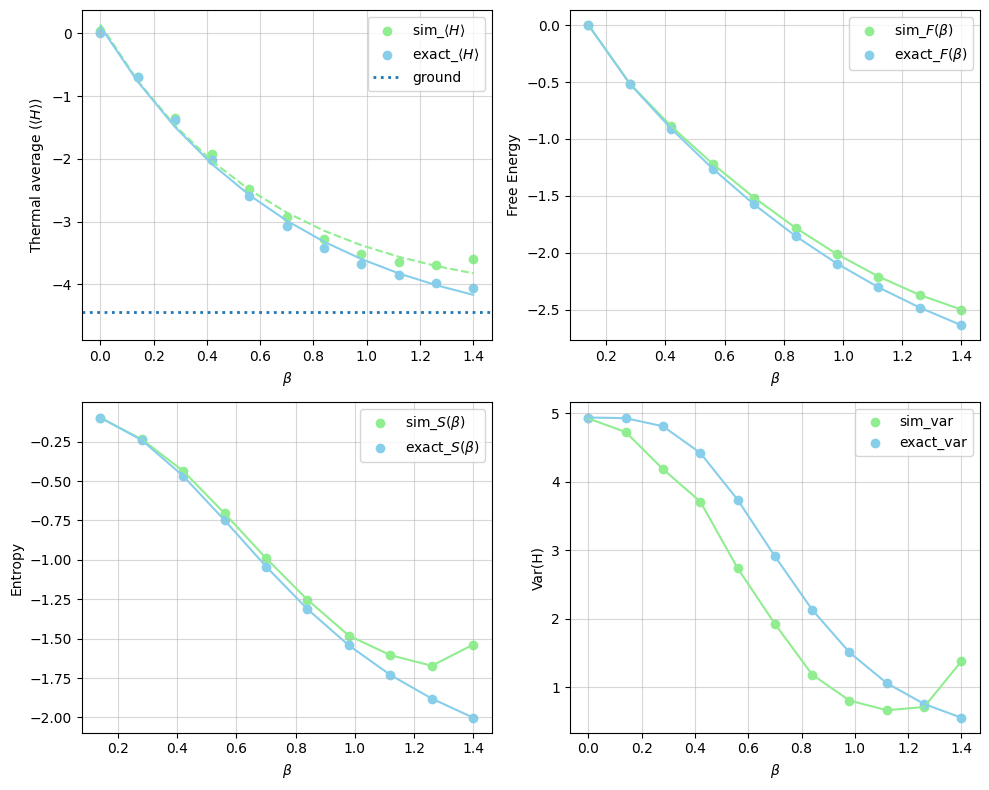

In [23]:
if __name__ == "__main__":
    """
    model: "tfim" or "xy"

    dimension: 1 for ID chain or 2 for 2D square lattice
    
    trotter_steps: recommended = 2 trotter_steps
    """
    
    output = run_model_experiment(model="xy", lattice_size=[2,2], trotter_steps=2)